In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

# GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
file = "file.txt"

splitted_line = []

with open(file) as f:
    for line in f.readlines():
        # print(line)
        splitted_line.append([line[0], line[2:]])


print(splitted_line.pop(0))



['5', '85\n']


In [17]:
dataset = pd.DataFrame(list(splitted_line), columns=["labels", "text"])

In [18]:
dataset.head()

,labels,text
0,1,champion products ch approves stock split cham...
1,2,computer terminal systems cpml completes sale ...
2,1,cobanco inc cbco year net shr cts vs dlrs net ...
3,1,am international inc am nd qtr jan oper shr lo...
4,1,brown forman inc bfd th qtr net shr one dlr vs...


In [27]:
X = dataset["text"].values
y = dataset["labels"].values

y = to_categorical(y)

In [28]:
tokenizer = Tokenizer(num_words= None)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Example
print(X[0])
print(sequences[0])

champion products ch approves stock split champion products inc said its board of directors approved a two for one stock split of its common shares for shareholders of record as of april the company also said its board voted to recommend to shareholders at the annual meeting april an increase in the authorized capital stock from five mln to mln shares reuter 

[1986, 189, 9296, 2397, 51, 163, 1986, 189, 28, 5, 17, 99, 2, 452, 362, 6, 59, 12, 52, 51, 163, 2, 17, 95, 45, 12, 115, 2, 80, 43, 2, 68, 1, 25, 60, 5, 17, 99, 1663, 3, 1778, 3, 115, 32, 1, 256, 155, 68, 42, 158, 4, 1, 1013, 173, 51, 22, 107, 8, 3, 8, 45, 15]


In [29]:
X_encoded = pad_sequences(sequences, maxlen=80, padding='post')

print(X_encoded[0])

[1986  189 9296 2397   51  163 1986  189   28    5   17   99    2  452
  362    6   59   12   52   51  163    2   17   95   45   12  115    2
   80   43    2   68    1   25   60    5   17   99 1663    3 1778    3
  115   32    1  256  155   68   42  158    4    1 1013  173   51   22
  107    8    3    8   45   15    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [30]:
# Split into training set and test set. Use a test size = 3000 and a random state = 0
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=3000, random_state=0,stratify = y)

In [48]:
# Design a LSTM neural network and use an embedding layer.
vocabulary_size = X_train.max()

model = Sequential()
model.add(Embedding(vocabulary_size+1, 150, input_length=100))
model.add(SpatialDropout1D(0.3))
#model.add(LSTM(200,return_sequences=True))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(500, activation='relu'))
model.add(Dense(9, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [49]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from datetime import datetime, date
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=4, restore_best_weights=True)

END = f'{datetime.timestamp(datetime.now())}_{date.today().strftime("%b-%d-%Y")}'

NAME = 'text_classification_model{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir=f'{NAME}_{END}')

checkpoint_filepath = f'text_classification_{END}.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

callback_list = [tensorboard, checkpointer, es]

In [51]:
history = model.fit(X_train, y_train, epochs=100,verbose=1,batch_size=32, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
63/63 [==============================] - 81s 1s/step - loss: 0.7468 - accuracy: 0.7077 - val_loss: 0.8438 - val_accuracy: 0.6720
Epoch 2/100
63/63 [==============================] - 85s 1s/step - loss: 0.8127 - accuracy: 0.7072 - val_loss: 0.9205 - val_accuracy: 0.6801
Epoch 3/100
63/63 [==============================] - 87s 1s/step - loss: 0.8776 - accuracy: 0.6615 - val_loss: 0.9203 - val_accuracy: 0.6640
Epoch 4/100
63/63 [==============================] - 89s 1s/step - loss: 0.8722 - accuracy: 0.6459 - val_loss: 0.9699 - val_accuracy: 0.6358
Epoch 5/100
63/63 [==============================] - 90s 1s/step - loss: 0.8270 - accuracy: 0.6740 - val_loss: 0.8753 - val_accuracy: 0.7163
Restoring model weights from the end of the best epoch: 1.
Epoch 5: early stopping


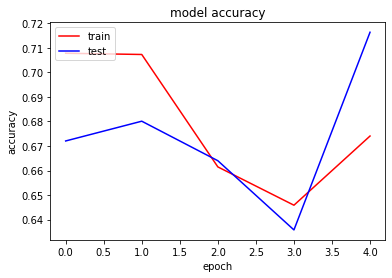

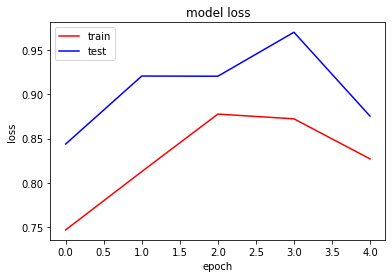

In [ ]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
rounded_labels=np.argmax(y_test, axis=1)


1

In [60]:
# Validate model on training set
y_pred = np.argmax(model.predict(X_test),axis=-1)

print(classification_report(rounded_labels, y_pred))

cf = confusion_matrix(rounded_labels, y_pred)

print(cf)
print(accuracy_score(rounded_labels, y_pred) * 100) 

              precision    recall  f1-score   support

           1       0.78      0.84      0.81      1553
           2       0.60      0.45      0.51       873
           3       0.47      0.39      0.43       137
           4       0.00      0.00      0.00        59
           5       0.00      0.00      0.00        23
           6       0.62      0.30      0.40       138
           7       0.03      0.02      0.02       104
           8       0.19      0.71      0.30       113

    accuracy                           0.63      3000
   macro avg       0.34      0.34      0.31      3000
weighted avg       0.64      0.63      0.62      3000

[[1309  227    0    0    0    0    7   10]
 [ 363  391    5    0    0    0   35   79]
 [   0    4   54    0    0   21    6   52]
 [   5    5   12    0    0    1    5   31]
 [   1    3    0    0    0    0    4   15]
 [   1    5   24    0    0   41    4   63]
 [   5    8    5    0    0    1    2   83]
 [   4    4   16    0    0    2    7   80]]
62.5

d:\GitHub\DirectSharePointProject\SharePointAI\envSharePoint\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\GitHub\DirectSharePointProject\SharePointAI\envSharePoint\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\GitHub\DirectSharePointProject\SharePointAI\envSharePoint\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  